### INTRO AND DESCRIPTION

This training notebook* is an attempt to solve the problem of the unfair ranking of restaurants in Trip Advisor. 

The task is the following. Based on the dataset provided, build a model which will evaluate and predict the real rating of the restaurant. In case of significant difference between the predicted rating and the current rating we may conclude that the current rating of the restaurant is most probably wrong.

Description of dataset: 

- **Restaurant_id**: identification number of the restaurant;
- **City**: the city of restaurant allocation;
- **Cuisine Style**: the cuisine(s) the restaurant offers;
- **Ranking**: position of the restaurant within in-city ranking;
- **Rating**: rating of the restaurant according to Trip Advisor data (this is the indicator the model should predict);
- **Price Range**: price range in the restaurant;
- **Number of Reviews**: number of reviews on the restaurant;
- **Reviews**: info on 2 reviews placed on the restaurant web-page;
- **URL_TA**: URL of the restaurant web-page on Trip Advisor;
- **ID_TA**: the restaurant id in Trip Advisor database

Modeling process is divided into logical steps, therefore for better user experience, please, *use TOC*

\* - *Python v3 code is written in Jupyter Notebook*  
\** - *restaurant is for restaurant / chain of restaurants* 
  

### LIBRARIES AND TOOLS

In [127]:
import pandas as pd
import numpy as np
import re
from datetime import date
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

### FUNCTIONS USED

In [128]:
def str_clean(x):
    
    x=str(x).replace(']','')
    x=str(x).replace('[','')
    x=str(x).replace('\'','')
    x=str(x).replace(' ','')
    
    return x

In [129]:
def txt_to_num (record):
    for key,value in dct.items():
        if record==key:
            record=value
        else: 
            continue
    return record

In [130]:
def c_count_groups (record):
    if (len(record)>=2) and (len(record)<=4):
        record=2
    elif len(record)>4:
        record=3
    else: 
        record=1
    return record

In [131]:
def p_count_groups (record):
    
    lst=[]
    
    for cuisine in record: 
        for i in range(0,len(popularity)):
            if cuisine==popularity.index[i]:
                lst.append(popularity[i])
            else: continue
        new_feature=min(lst)
    return new_feature

In [132]:
def date_selection(record):
    
    temp=str(record).split(',')
    
    if len(temp)==2:
        a=datetime.datetime.strptime(temp[0],'%m/%d/%Y')
        b=datetime.datetime.strptime(temp[1],'%m/%d/%Y')
        
        if a>=b:
            temp=a
           
        else:
            temp=b
        return temp

In [133]:
def date_delta(record):
    
    temp=str(record).split(',')
    
    if len(temp)==2:
        a=datetime.datetime.strptime(temp[0],'%m/%d/%Y')
        b=datetime.datetime.strptime(temp[1],'%m/%d/%Y')
        
        temp=abs(a-b)
         
        return temp

In [134]:
def outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3-Q1
    l_boundary=Q1-1.5*IQR
    h_boundary=Q3+1.5*IQR
    
    outliers = column[~column.between(l_boundary, h_boundary)]
    print('Minor boundries are ({},{})\n There are {} outlying values'\
          .format(l_boundary,h_boundary,outliers.count()))
    
    inp=input('Clear outliers?\n Input Y (for yes) or N (for no): ')
    
    if inp=='Y': 
        if (type(l_boundary)==int)|(type(l_boundary)==np.float64):
            column=column[column.between(l_boundary, h_boundary)]
        else: 
            column=column[column.between(str(l_boundary), str(h_boundary))]
    else: 
        column=column
    
    return column

### DATA LOADING and OVERVIEW

In [135]:
df=pd.read_csv('main_task.csv')

In [136]:
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [137]:
df=df.drop(['URL_TA','ID_TA'],axis=1)

In [138]:
df.columns

Index(['Restaurant_id', 'City', 'Cuisine Style', 'Ranking', 'Rating',
       'Price Range', 'Number of Reviews', 'Reviews'],
      dtype='object')

In [139]:
df.columns=['rest_id','city','cuisine','ranking','rating','price_range',
            'number_of_reviews','reviews']

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rest_id            40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine            30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.4+ MB


### PREPROCESSING and FEATURE ENGINEERING

#### price_range

In [141]:
df.price_range.value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: price_range, dtype: int64

In [142]:
df.price_range=df.price_range.apply(lambda x: 1 if x=='$$ - $$$' else x)

In [143]:
df.price_range=df.price_range.apply(lambda x: 0 if x=='$' else x)

In [144]:
df.price_range=df.price_range.apply(lambda x: 2 if x=='$$$$' else x)

Obviously average priced restaurants are most common in dataframe, so we will consider the restaurants with 'nan' value under this column as restaurants with average pricing.

In [145]:
df.price_range.fillna(1,inplace=True)

In [146]:
df.price_range.value_counts()

1.0    32298
0.0     6279
2.0     1423
Name: price_range, dtype: int64

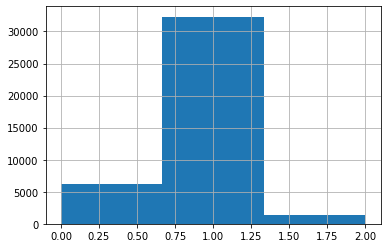

In [147]:
df.price_range.hist(bins=3)

#### city

In [148]:
df.city.nunique()

31

In [149]:
df.city.value_counts().index

Index(['London', 'Paris', 'Madrid', 'Barcelona', 'Berlin', 'Milan', 'Rome',
       'Prague', 'Lisbon', 'Vienna', 'Amsterdam', 'Brussels', 'Hamburg',
       'Munich', 'Lyon', 'Stockholm', 'Budapest', 'Warsaw', 'Dublin',
       'Copenhagen', 'Athens', 'Edinburgh', 'Zurich', 'Oporto', 'Geneva',
       'Krakow', 'Oslo', 'Helsinki', 'Bratislava', 'Luxembourg', 'Ljubljana'],
      dtype='object')

City names are to be changed to numbers in order to be usable for the predicting model

In [150]:
dct={}
for i in range(0,df.city.nunique()):
    dct[df.city.value_counts().index[i]]=i

In [151]:
df.city=df.city.apply(txt_to_num)

In [152]:
df.city.value_counts()

0     5757
1     4897
2     3108
3     2734
4     2155
5     2133
6     2078
7     1443
8     1300
9     1166
10    1086
11    1060
12     949
13     893
14     892
15     820
16     816
17     727
18     673
19     659
20     628
21     596
22     538
23     513
24     481
25     443
26     385
27     376
28     301
29     210
30     183
Name: city, dtype: int64

#### cuisine

In [153]:
df.cuisine=df.cuisine.apply(str_clean)

In [154]:
df.cuisine=df.cuisine.apply(lambda x: str(x).split(','))

In [155]:
cuisines=set()

for record in df.cuisine:
    for cuisine in record:
        cuisines.add(cuisine)

len(cuisines)

126

The average count of cuisines per restaurant will be:

In [156]:
count_p_rest = [] 

for record in df.cuisine:
    count_p_rest.append(len(record))

In [157]:
round(sum(count_p_rest)/len(count_p_rest),1)

2.6

Count of cuisines per restaurant might be helpful for our model, so we will add a new column to our dataframe with that information.

In [158]:
temp=df.cuisine.apply(lambda x: len(x))

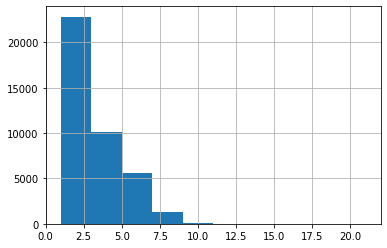

In [159]:
temp.hist()

In [160]:
temp.value_counts()

1     16547
2      6294
3      5306
4      4799
5      3606
6      2043
7      1022
8       283
9        76
10       19
11        3
21        1
13        1
Name: cuisine, dtype: int64

It is clear that most of the database restaurants have only 1 cuisine in their menu* and more then 80% of them** serve only 4 or less cuisines in their menu. We will use this information to break restaurants in 3 groups in our new column: 
1. serving 1 cuisine 
2. serving 2 to 4 cuisines
3. serving more than 4 cuisines

\* - *restaurants with 'nan' information on cuisines they serve are assumed to have at least 1 cuisine* 

\** - *around 32 000 of 40 000*

In [161]:
df['cuisines_count']=df.cuisine.apply(c_count_groups)

In [162]:
df.cuisines_count

0        2
1        1
2        3
3        1
4        2
        ..
39995    2
39996    3
39997    2
39998    3
39999    1
Name: cuisines_count, Length: 40000, dtype: int64

Investigating popularity of cuisines among restaurants:

In [163]:
freq = {} 
for cuisine in cuisines:  
    freq[cuisine] = 0
for record in df.cuisine:   
    for cuisine in record:  
        freq[cuisine] += 1  

In [164]:
popularity=pd.Series(freq).sort_values(ascending=False)
popularity

VegetarianFriendly    11189
European              10060
nan                    9283
Mediterranean          6277
Italian                5964
                      ...  
Yunnan                    1
Latvian                   1
Salvadoran                1
Xinjiang                  1
Burmese                   1
Length: 126, dtype: int64

In [165]:
df.cuisine.head(3)

0                    [European, French, International]
1                                                [nan]
2    [Japanese, Sushi, Asian, Grill, VegetarianFrie...
Name: cuisine, dtype: object

It is clear that some cuisines are much more popular in restaurants than the others, so the fact that the restaurant is serving dishes of one cuisine and not serving dishes from other one might affect the rating. There's a huge number of restaurants with 'nan' information on this topic (9283 !) we cannot remove that much information from datasheet and at this very step we do not have enough information to replace 'nan' to smth more useful. So we will break restaurants in 3 groups:
1. serving top-10 cuisines according to popularity list attained above
2. with 'nan' information 
3. the rest

This information will be then added to a new column in datasheet. If some particular restaurant serves cuisines from different groups then it is assigned to a group which is more popular. 

In [166]:
top_10=popularity.quantile(0.90)

In [167]:
popularity[popularity<top_10]=3
popularity[popularity.index=='nan']=2
popularity[popularity>=top_10]=1

In [168]:
df['c_popularity']=df.cuisine.apply(p_count_groups)

In [169]:
df['c_popularity']

0        1
1        2
2        1
3        2
4        1
        ..
39995    1
39996    1
39997    3
39998    1
39999    1
Name: c_popularity, Length: 40000, dtype: int64

#### reviews

In [170]:
df.reviews.head()

0    [['Good food at your doorstep', 'A good hotel ...
1    [['Unique cuisine', 'Delicious Nepalese food']...
2    [['Catch up with friends', 'Not exceptional'],...
3                                             [[], []]
4    [['Best place to try a Bavarian food', 'Nice b...
Name: reviews, dtype: object

In [171]:
df.reviews[0]

"[['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]"

In [172]:
df.reviews[1]

"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]"

In [173]:
df.reviews.describe()

count        40000
unique       33516
top       [[], []]
freq          6471
Name: reviews, dtype: object

This column expectedly has many unique records, but in general data is presented here is either equal to \'[[], []]' (meaning there are no reviews on restaurant) or is presented in a format of \'[[text], [date,date]]'. Text part is hardly useful, but dates contain some important information, so the text part is to be thrown away and the dates are to be kept.

In [174]:
pattern=re.compile('\d\d/\d\d/\d\d*')

In [175]:
df.reviews=df.reviews.apply(lambda x:pattern.findall(str(x)) )

In [176]:
df.reviews=df.reviews.apply(str_clean)

In [177]:
df.reviews.head()

0    12/31/2017,11/20/2017
1    07/06/2017,06/19/2016
2    01/08/2018,01/06/2018
3                         
4    11/18/2017,02/19/2017
Name: reviews, dtype: object

In [178]:
df.reviews.describe()

count     40000
unique    24606
top            
freq       6471
Name: reviews, dtype: object

In [179]:
df.reviews.head(20)

0     12/31/2017,11/20/2017
1     07/06/2017,06/19/2016
2     01/08/2018,01/06/2018
3                          
4     11/18/2017,02/19/2017
5     09/16/2017,05/31/2017
6     08/04/2017,11/05/2017
7     02/16/2014,06/13/2012
8                          
9     11/07/2017,03/27/2017
10                         
11    12/15/2017,11/22/2017
12    01/07/2018,12/27/2017
13    07/25/2017,05/30/2017
14                         
15    12/01/2017,09/14/2017
16               04/12/2017
17    02/28/2017,10/31/2016
18    08/16/2017,10/21/2016
19    04/12/2016,08/13/2015
Name: reviews, dtype: object

We will add to the dataframe 2 new columns with the freshest date of reviews and the difference in time between the two reviews.

In [180]:
df['rev_date']=df.reviews.apply(date_selection)

In [181]:
df.rev_date.describe()

count                   28973
unique                   1498
top       2018-01-07 00:00:00
freq                      515
first     2008-04-07 00:00:00
last      2018-02-26 00:00:00
Name: rev_date, dtype: object

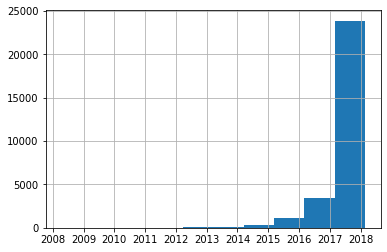

In [182]:
df.rev_date.hist();

In [183]:
df.rev_date.fillna(df.rev_date.mean(),inplace=True)

In [184]:
df.rev_date=outliers(df.rev_date)

Minor boundries are (2016-12-09 03:39:05.038474240,2018-06-23 12:12:32.976915456)
 There are 4016 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


In [185]:
df.rev_date=df.rev_date.apply(lambda x: round((x-datetime.datetime(1970, 1,1)).days),0)

In [186]:
df.rev_date.describe()

count     40000
unique     1498
top       17354
freq      11060
Name: rev_date, dtype: int64

In [187]:
df.rev_date=df.rev_date/df.rev_date.mean()

In [188]:
df.rev_date

0         1.01017
1        0.999915
2         1.01063
3        0.999972
4         1.00769
           ...   
39995     1.00931
39996      1.0096
39997    0.985797
39998      1.0002
39999    0.969836
Name: rev_date, Length: 40000, dtype: object

In [189]:
df['rev_date_delta']=df.reviews.apply(date_delta)

In [190]:
df.rev_date_delta=df.rev_date_delta[~df.rev_date_delta.isna()].dt.days.astype('int16')

Too many empty reviews, not enough information to fill them with some useful information. All those empty reviews we will replace with -1 to separate them from the others that have at least 1 review.

In [191]:
df.rev_date_delta.fillna(-1,inplace=True)

In [192]:
df.rev_date_delta.describe()

count    40000.000000
mean       102.370000
std        198.737148
min         -1.000000
25%         -1.000000
50%         28.000000
75%        120.000000
max       3207.000000
Name: rev_date_delta, dtype: float64

In [193]:
df.rev_date_delta.value_counts()

-1.0       11027
 1.0         664
 2.0         523
 3.0         496
 0.0         492
           ...  
 2940.0        1
 1818.0        1
 1032.0        1
 722.0         1
 1543.0        1
Name: rev_date_delta, Length: 1229, dtype: int64

In [194]:
df.rev_date_delta.max()

3207.0

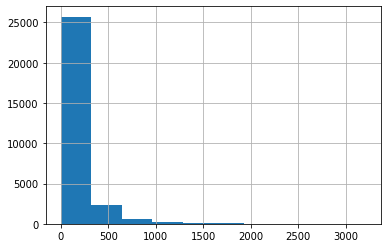

In [195]:
df.rev_date_delta[df.rev_date_delta>=0].hist();

In [196]:
df.rev_date_delta=outliers(df.rev_date_delta)

Minor boundries are (-182.5,301.5)
 There are 3565 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


In [197]:
df.rev_date_delta=outliers(df.rev_date_delta)

Minor boundries are (-182.5,301.5)
 There are 3565 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


#### number_of_reviews

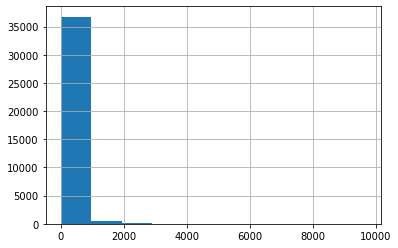

In [198]:
df.number_of_reviews.hist()

In [199]:
df.number_of_reviews.describe()

count    37457.000000
mean       124.825480
std        295.666352
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: number_of_reviews, dtype: float64

In [200]:
df.number_of_reviews=outliers(df.number_of_reviews)

Minor boundries are (-150.0,274.0)
 There are 4348 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): N


Too many outlying values , cannot be cleared, but it is highly possible that the outlying part itself has outlying positions.

In [201]:
df.number_of_reviews[df.number_of_reviews>274]=\
outliers(df.number_of_reviews[df.number_of_reviews>274])

Minor boundries are (-277.875,1407.125)
 There are 316 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): Y


In [202]:
df.number_of_reviews.fillna(df.number_of_reviews.mean(),inplace=True)

In [203]:
df.number_of_reviews.describe()

count    40000.000000
mean       106.223150
std        181.044762
min          2.000000
25%         10.000000
50%         38.000000
75%        106.223150
max       1407.000000
Name: number_of_reviews, dtype: float64

#### ranking

In [204]:
df.ranking.describe()

count    40000.000000
mean      3676.028525
std       3708.749567
min          1.000000
25%        973.000000
50%       2285.000000
75%       5260.000000
max      16444.000000
Name: ranking, dtype: float64

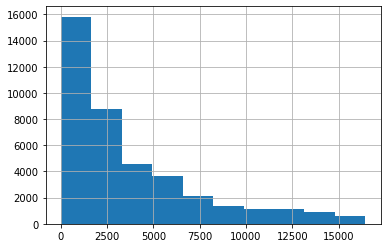

In [205]:
df.ranking.hist()

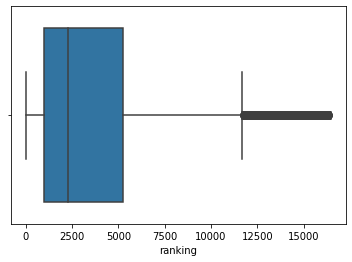

In [206]:
sns.boxplot(df.ranking)

In [207]:
df.ranking=outliers(df.ranking)

Minor boundries are (-5457.5,11690.5)
 There are 2450 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): Y


In [208]:
df.ranking.fillna(df.ranking.mean(),inplace=True)

#### rating

In [209]:
df.rating.describe()

count    40000.000000
mean         3.993037
std          0.668417
min          1.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [210]:
df.rating.value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: rating, dtype: int64

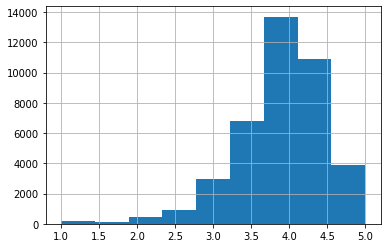

In [211]:
df.rating.hist(bins=df.rating.nunique())

In [212]:
df.rating=outliers(df.rating)

Minor boundries are (2.0,6.0)
 There are 340 outlying values
Clear outliers?
 Input Y (for yes) or N (for no): Y


In [213]:
df.rating.fillna(df.rating.mean(),inplace=True);

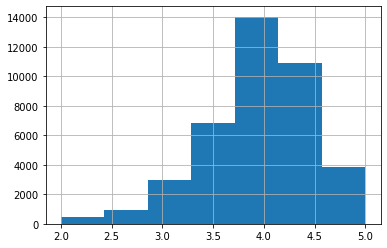

In [214]:
df.rating.hist(bins=7);

### DATA ANALYSIS

In [215]:
df.columns

Index(['rest_id', 'city', 'cuisine', 'ranking', 'rating', 'price_range',
       'number_of_reviews', 'reviews', 'cuisines_count', 'c_popularity',
       'rev_date', 'rev_date_delta'],
      dtype='object')

In [216]:
numeric=['cuisines_count','ranking','number_of_reviews',
         'rev_date_delta','rating']
categorial=['city', 'price_range','c_popularity', 'rev_date']

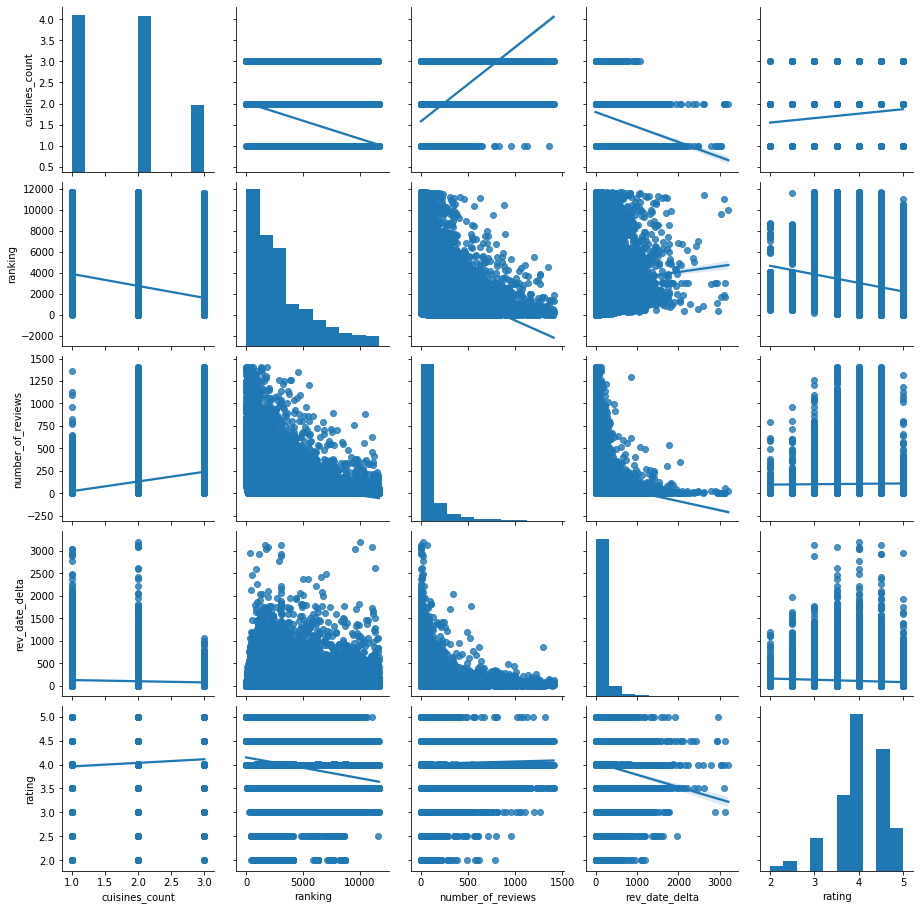

In [217]:
sns.pairplot(df[numeric], kind='reg')

In [218]:
df[numeric].corr()

,cuisines_count,ranking,number_of_reviews,rev_date_delta,rating
cuisines_count,1.000000,-0.312863,0.436637,-0.096570,0.088866
ranking,-0.312863,1.000000,-0.270931,0.041209,-0.187883
number_of_reviews,0.436637,-0.270931,1.000000,-0.111386,0.014785
rev_date_delta,-0.096570,0.041209,-0.111386,1.000000,-0.082561
rating,0.088866,-0.187883,0.014785,-0.082561,1.000000


For both numeric and category data no obviously strong correlation found out.

In [219]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column, y='rating', data=df)
    ax.set_title('Boxplot for ' + column)
    plt.show()

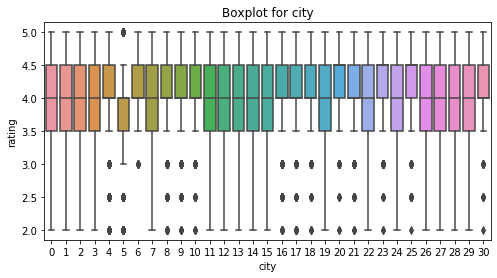

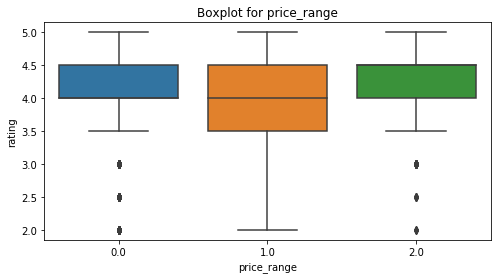

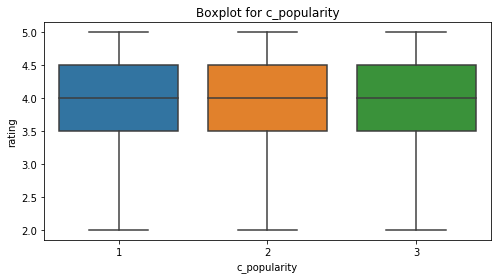

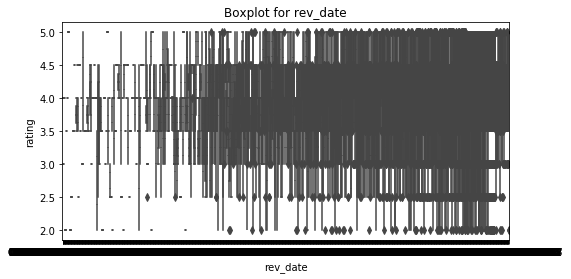

In [220]:
for column in categorial:
    get_boxplot(column)

### MACHINE LEARNING

In [234]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = df.drop(['rest_id', 'rating','reviews','cuisine'], axis = 1)  
y = df['rating']  
  
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
  
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

In [235]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

In [236]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  

MAE: 0.22151728700698878
